# Sky with the Moon Up

* https://desi.lbl.gov/trac/wiki/CommissioningCommissioningPlanning/commishdata#NightSky
* https://portal.nersc.gov/project/desi/collab/nightwatch/kpno/20191112/exposures.html
* http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-11-12/nightsum.html

**Data**  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112  
* /global/projecta/projectdirs/desi/spectro/redux/daily/exposures/20191112
* Exposures 27337-27396

**Data Model**  
* https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures/NIGHT/EXPID/sky-CAMERA-EXPID.html

John Moustakas

In [1]:
import os
import numpy as np
import fitsio

In [2]:
import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits

In [3]:
import desispec.io
import desimodel.io

In [4]:
import speclite
rfilt = speclite.filters.load_filters('decam2014-r')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set(context='talk', style='ticks', font_scale=1.1)
%matplotlib inline

In [7]:
topdir = os.getenv('DESI_ROOT')+'/spectro'
gfadir = '/project/projectdirs/desi/users/ameisner/GFA/reduced/v0001'

#### Specify the night and range of GFA and spectrograph exposure IDs.

In [8]:
night = 20191112
expid_start, expid_end = 27337, 27396
expids = np.arange(expid_end - expid_start + 1) + expid_start

#### Read A. Meisner's reductions to get the sky background in the GFAs vs moon separation.

In [9]:
def read_gfa(night, expid, raw=False):
    sexpid = '{:08d}'.format(expid)
    rawfname = topdir+'/data/{0}/{1}/gfa-{1}.fits.fz'.format(night, sexpid)
    fname = gfadir+'/{0}/{1}/gfa-{1}_ccds.fits'.format(night, sexpid)    
    if os.path.isfile(fname):
        # get the target-moon separation
        hdr = fitsio.read_header(rawfname, ext=1)
        #print(hdr)
        
        ra, dec, moonra, moondec = hdr['SKYRA'], hdr['SKYDEC'], hdr['MOONRA'], hdr['MOONDEC']
        csky = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        cmoon = SkyCoord(ra=moonra*u.degree, dec=moondec*u.degree, frame='icrs')
        moonsep = np.array(csky.separation(cmoon).value).astype('f4') # [degree]

        #print('Reading {}'.format(fname))
        data = Table.read(fname)
        #print(data.colnames)
        
        # pack into a table
        out = Table()
        out['sky_mag_ab'] = [np.mean(data['sky_mag_ab'])]
        out['sky_mag_ab_err'] = [np.std(data['sky_mag_ab']) / np.sqrt(len(data))]
        out['moonsep'] = [moonsep]
        out['airmass'] = [hdr['AIRMASS']]
        return out
    else:
        return None

In [10]:
def gfa_sky(night):
    out = []
    for expid in expids:
        dd = read_gfa(night, expid)
        if dd is not None:
            out.append(dd)
    return vstack(out)

In [11]:
#data = read_gfa(night, 27337)
#data

In [12]:
gfa = gfa_sky(night)
gfa

sky_mag_ab,sky_mag_ab_err,moonsep,airmass
float64,float64,float32,float64
14.749320711915209,0.059598433549924446,10.993231,1.14189
14.750914327694213,0.06008108582271851,10.99818,1.138029
14.75067592611739,0.06033143344319213,11.000665,1.135532
14.750598611223268,0.060667852081627185,11.003156,1.133065
14.750583401196975,0.06106180752520087,11.005651,1.130409
14.962776953461022,0.059492423629957276,14.5302105,1.081853
14.96206024700866,0.05970604303849887,14.535055,1.080074
14.961648766262476,0.06003596890603652,14.539873,1.078306
14.960030458927479,0.060430968753942986,14.5447,1.076472


In [13]:
gfa[12:25]

sky_mag_ab,sky_mag_ab_err,moonsep,airmass
float64,float64,float32,float64
14.947014629741645,0.12357760810831168,19.881807,1.036005
14.947415415326807,0.12403613334625924,19.887901,1.034853
14.94690665926297,0.1242999830011797,19.894001,1.033811
15.07982183745264,0.13508716377411545,24.571959,1.016123
15.189484859879856,0.16334708072351672,24.578554,1.015535
15.226155168976923,0.1737412020378606,24.585136,1.014965
15.222328612201466,0.1730211368518501,24.591717,1.014365
15.218214430301515,0.17242540475719506,24.59831,1.013835
16.433207923659257,0.018893493440196422,29.64331,1.006739


Text(0,0.5,'Sky Brightness (AB mag)')

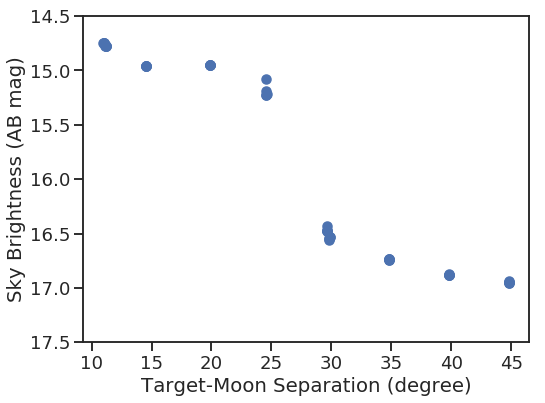

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(gfa['moonsep'], gfa['sky_mag_ab'])
#ax.invert_yaxis()
ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('Sky Brightness (AB mag)')

#### Read the spectroscopic reductions to get the sky spectra vs moon separation.

In [15]:
def read_spec(night, expid):
    sexpid = '{:08d}'.format(expid)
    datadir = topdir+'/redux/daily/exposures/{}/{}/'.format(night, sexpid)
    if os.path.isdir(datadir):
        #fr = desispec.io.read_frame('{}/frame-r3-{}.fits'.format(datadir, sexpid))
        sp = desispec.io.read_frame('{}/sframe-r3-{}.fits'.format(datadir, sexpid))
        sky = desispec.io.read_sky('{}/sky-r3-{}.fits'.format(datadir, sexpid))
        return sp, sky
        #return fr, sp, sky
    else:
        return None, None    

In [16]:
#sp, sky = read_spec(night, 27339)

In [17]:
def spec_sky():
    moonsep, meansky, stdsky = [], [], []
    for expid in expids:
        sp, sky = read_spec(night, expid)
        if sky is not None:
            # hack for getting the object-moon separation!!
            moonsep.append(sky.header['PROGRAM'][:3])
            
            # convolve the spectrum with the r-band filter curve
            keep = sp.fibermap['OBJTYPE'] == 'SKY'
            padflux, padwave = rfilt.pad_spectrum(sky.flux[keep, :], sky.wave, method='edge')
            abmags = rfilt.get_ab_magnitudes(padflux, padwave)['decam2014-r']
            
            meansky.append(np.mean(abmags))
            stdsky.append(np.std(abmags) / np.sqrt(len(abmags)))
            
            #meansky.append( np.mean(np.median(sky.flux[keep, :], axis=1)) )
            #stdsky.append( np.std(np.median(sky.flux[keep, :], axis=1)) )
            
    out = Table()
    out['moonsep'] = np.hstack(moonsep).astype('f4')
    out['meansky'] = np.hstack(meansky).astype('f4')
    out['stdsky'] = np.hstack(stdsky).astype('f4')
    
    return out

In [18]:
spec = spec_sky()
spec

moonsep,meansky,stdsky
float32,float32,float32
10.0,-29.947975,8.217153e-06
15.0,-29.659554,8.634799e-06
20.0,-29.366314,6.9720595e-06
25.0,-29.107344,9.158272e-06
30.0,-28.444647,9.290993e-06
35.0,-28.270079,8.730505e-06
40.0,-28.144033,1.0303747e-05
45.0,-28.056417,9.786631e-06
30.0,-28.431787,8.088821e-06


Text(0.5,1,'Night 20191112')

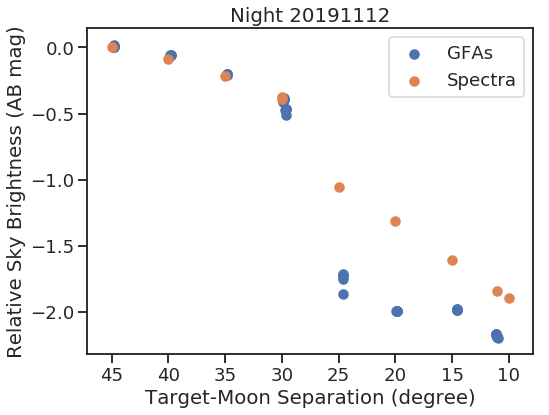

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

gfaref = gfa['sky_mag_ab'][gfa['moonsep'].argmax()]
specref = spec['meansky'][spec['moonsep'].argmax()]

ax.scatter(gfa['moonsep'], gfa['sky_mag_ab'] - gfaref, label='GFAs')
ax.scatter(spec['moonsep'], spec['meansky'] - specref, label='Spectra')
ax.invert_xaxis()
#ax.set_ylim(17.5, 14.5)
ax.set_xlabel('Target-Moon Separation (degree)')
ax.set_ylabel('Relative Sky Brightness (AB mag)')
ax.legend()
ax.set_title('Night {}'.format(night))